# HW1 - Q1,Q2,Q3

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import KNeighborsClassifier

loading training and data sets

In [2]:
dataset_dir = "https://raw.githubusercontent.com/probml/pmtkdata/master/knnClassify3c/"
train_dataset_path = dataset_dir + "knnClassify3cTrain.txt"
test_dataset_path = dataset_dir + "knnClassify3cTest.txt"
# Train dataset
train_dataset = pd.read_csv(train_dataset_path,
 names=["x1", "x2", "class"],
 delimiter=" ")
X_train = train_dataset.iloc[:, :-1].values
y_train = train_dataset.iloc[:, -1].values
# Test dataset
test_dataset = pd.read_csv(test_dataset_path,
 names=["x1", "x2", "class"],
 delimiter=" ")
X_test = test_dataset.iloc[:, :-1].values
y_test = test_dataset.iloc[:, -1].values

Q1: plot a pairs plot and a box-whisker plot based using the training set

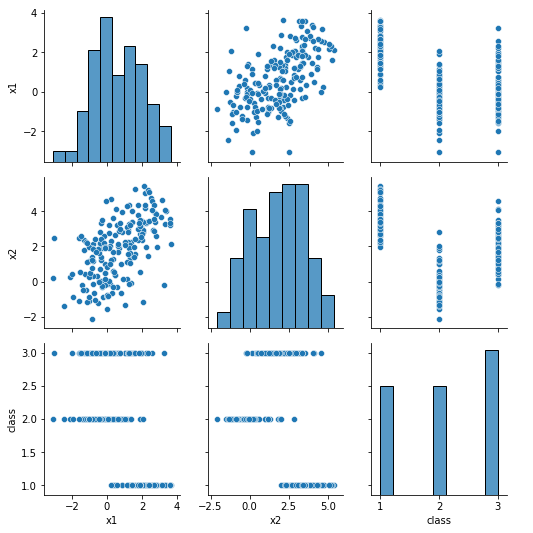

In [3]:
#pairs plot
_=sns.pairplot(train_dataset)

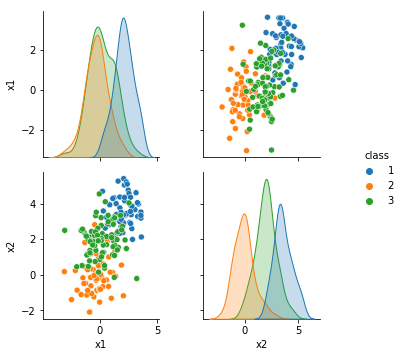

In [4]:
#change class to categorical variable
train_dataset['class'] = train_dataset['class'].astype('category',copy=False)

_=sns.pairplot(train_dataset, hue='class')

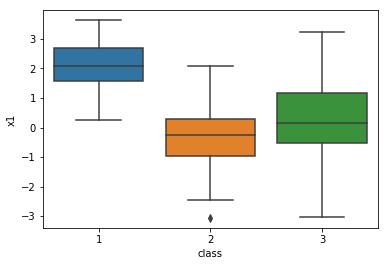

In [5]:
#  box-whisker plot
_ = sns.boxplot(x=train_dataset["class"], y=train_dataset["x1"])

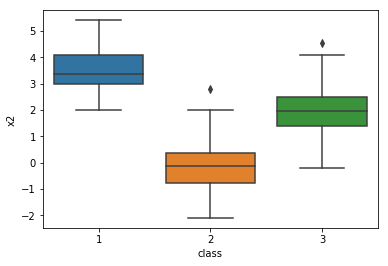

In [6]:
_ = sns.boxplot(x=train_dataset["class"], y=train_dataset["x2"])


Q2: Based on visual inspection of the pairs plot, write a function that classifies based on rules

In [7]:
def predict(x):
    x1, x2 = x
    if (x1 < 0.5 and x2 < 0.5):
        res_class = 2
    elif x1 > 1 and x2 > 2:
        res_class = 1
    else:
        res_class = 3
    return res_class

Q3: Apply the rule based classifier in (2) to predict the the test set and report the misclassification rate

In [8]:
def calc_mce(pred, gold):
    counter = 0
    for p, g in zip(pred, gold):
        if p != g:
            counter += 1
    return counter / len(pred)

In [9]:
def part_3(X_test, y_test):
    pred = np.apply_along_axis(predict, 1, X_test)
    mce = calc_mce(pred, y_test)
    print('The misclassification rate of manual classifier is: %.3f' % (mce))

In [10]:
part_3(X_test, y_test)

The misclassification rate of manual classifier is: 0.268


Q4: Apply k-NN (use this function) on the the test set and plot the miscalssification rate for k=1, k=5 and k=10 (plot misclassification rate v.s. 1/k).

For k = 1 the misclassification rate of sklearn KNN is: 0.266
For k = 5 the misclassification rate of sklearn KNN is: 0.196
For k = 10 the misclassification rate of sklearn KNN is: 0.194


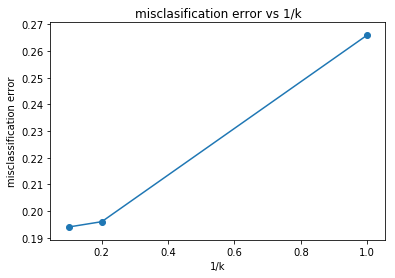

In [11]:
def sklearn_knn(X_train, y_train, X_test, y_test, k):
    neigh = KNeighborsClassifier(n_neighbors = k) #, weights = lambda x: np.where(x == 0, 1, 1 / (x ** 2))) # this was used as sanity check for part 7
    neigh.fit(X_train, y_train)
    pred = neigh.predict(X_test)
    mce = calc_mce(pred, y_test)
    print('For k = %d the misclassification rate of sklearn KNN is: %.3f' % (k, mce))
    return mce

def part_4(X_train, y_train, X_test, y_test):
    ks = [1, 5, 10]
    mces = []
    for k in ks:
        mces.append(sklearn_knn(X_train, y_train, X_test, y_test, k))
    ks = [1/k for k in ks]
    plt.plot(ks, mces)
    plt.scatter(ks, mces)
    plt.xlabel('1/k')
    plt.ylabel('misclassification error')
    plt.title('misclasification error vs 1/k')
    plt.show()
    
part_4(X_train, y_train, X_test, y_test)

Q5: Apply the k-NN naïve implementation here on the test set (with k=1) and calculate the misclassification rate

In [12]:
class KNearestNeighbors:
    """
    Simple implementation of a k-NN estimator.
    """
    def __init__(self, n_neighbors: int = 1) -> None:
        self.k = n_neighbors
        self.X_train = None
        self.y_train = None

    def fit(self, X_train: np.ndarray, y_train: np.ndarray) -> None:
        """
        Set the train dataset attributes to be used for prediction.
        """
        self.X_train = X_train
        self.y_train = y_train

    def get_neighbor_classes(self, observation: np.ndarray) -> np.ndarray:
        """
        Returns an array of the classes of the *k* nearest neighbors.
        """
        distances = np.sqrt(np.sum((self.X_train - observation) ** 2, axis = 1))

        # Create an array of training set indices ordered by their
        # distance from the current observation
        indices = np.argsort(distances, axis = 0)

        selected_indices = indices[:self.k]
        return self.y_train[selected_indices], distances[selected_indices]

    def estimate_class(self, observation: np.ndarray) -> int:
        """
        Estimates to which class a given row (*observation*) belongs.
        """
        neighbor_classes, _ = self.get_neighbor_classes(observation)
        classes, counts = np.unique(neighbor_classes, return_counts = True)
        return classes[np.argmax(counts)]

    def estimate_class_weighted(self, observation: np.ndarray) -> int:
        """
        Estimates to which class a given row (*observation*) belongs with the weighted prediction.
        """
        neighbor_classes, distances = self.get_neighbor_classes(observation)
        weights =  np.where(distances == 0, 1, 1 / (distances ** 2))
        classes = np.unique(neighbor_classes)
        best_c, best_w = 0, 0
        for c in np.nditer(classes):
            w = np.sum(weights[np.nonzero(neighbor_classes == c)])
            best_w, best_c = (w, c) if w > best_w else (best_w, best_c)
        return best_c

    def predict(self, X: np.ndarray):
        """
        Apply k-NN estimation for each row in a given dataset.
        """
        return np.apply_along_axis(self.estimate_class, 1, X)

    def predict_weighted(self, X: np.ndarray):
        """
        Apply k-NN estimation for each row in a given dataset with weighted predictions.
        """
        return np.apply_along_axis(self.estimate_class_weighted, 1, X)


In [13]:
kinds = ['naive', 'weighted']

def part_5(X_train, y_train, X_test, y_test, k, kind = 'naive'):
    assert kind in kinds
    neigh = KNearestNeighbors(n_neighbors = k)
    neigh.fit(X_train, y_train)
    if kind == 'naive':
        pred = neigh.predict(X_test)
    else:
        pred = neigh.predict_weighted(X_test)
    mce = calc_mce(pred, y_test)
    print('For k = %d the misclassification rate for %s KNN is: %.3f' % (k, kind, mce))
    return mce

part_5(X_train, y_train, X_test, y_test, 1)

For k = 1 the misclassification rate for naive KNN is: 0.266


0.266

Q6: Modify the code in (5) so that it implements a distance weighted k-NN
This part was done under the KNearestNeighbors class, see the functions predict_wighted and estimate_class_weighted.

Q7: Repeat (4) by using the modified code from (6).

For k = 1 the misclassification rate for weighted KNN is: 0.266
For k = 5 the misclassification rate for weighted KNN is: 0.240
For k = 10 the misclassification rate for weighted KNN is: 0.230


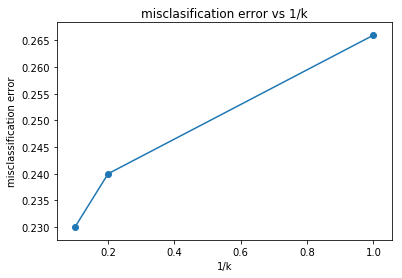

In [14]:
def part_7(X_train, y_train, X_test, y_test):
    ks = [1, 5, 10]
    mces = []
    for k in ks:
        mces.append(part_5(X_train, y_train, X_test, y_test, k, kind = 'weighted'))
    ks = [1/k for k in ks]
    plt.plot(ks, mces)
    plt.scatter(ks, mces)
    plt.xlabel('1/k')
    plt.ylabel('misclassification error')
    plt.title('misclasification error vs 1/k')
    plt.show()
    
part_7(X_train, y_train, X_test, y_test)